In [287]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [288]:
import numpy as np
import os
import tensorflow as tf

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

from nets import inception

from tensorflow.contrib import slim

image_size = inception.inception_v4.default_image_size

In [289]:
import time
import datetime
import math

In [290]:
import uuid
import os

In [291]:
import pickle

In [292]:
import moviepy
import moviepy.editor
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import imageio
import json
import re

In [293]:
from box_client import get_box_client

In [294]:
client = get_box_client()

In [295]:
rat_video_folder = client.folder('61116096312')
rat_video_feature_folder = client.folder('67339798174')

In [296]:
box_video_ids = {}
VID_PAT = re.compile("(\w+).(MPG|MP4)$")
for day_folder in rat_video_folder.get_items():
    try:
        d = datetime.datetime.strptime(day_folder.name, "%b %d %Y")
        d_str = d.strftime("%Y-%m-%d")
        box_video_ids[d_str] = {}
    except Exception as e:
        print("Unable to parse " + day_folder.name)
        continue
    for cage_folder in day_folder.get_items():
        box_video_ids[d_str][cage_folder.name] = {}
        for video in cage_folder.get_items():
            m = VID_PAT.match(video.name)
            if m:
                box_video_ids[d_str][cage_folder.name][m.groups()[0]] = video.id

"GET https://api.box.com/2.0/folders/61116096312/items?offset=0" 401 0
{'Date': 'Tue, 19 Feb 2019 08:28:17 GMT', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Strict-Transport-Security': 'max-age=31536000', 'WWW-Authenticate': 'Bearer realm="Service", error="invalid_token", error_description="The access token provided is invalid."', 'BOX-REQUEST-ID': '0e2bbql0gusbhh9q1927pv0i0rv', 'Age': '0'}
b''



Unable to parse practice seizures at 23 min in 71-2 and 70-3.MPG


In [301]:
box_feature_folder_ids = {}
existing_days = {}
for day_folder in rat_video_feature_folder.get_items():
    existing_days[day_folder.name] = day_folder.id
for day in box_video_ids:
    box_feature_folder_ids[day] = {}
    if day in existing_days:
        day_folder = client.folder(existing_days[day]).get()
    else:
        day_folder = rat_video_feature_folder.create_subfolder(day)
        
    existing_pos = {}
    for pos in day_folder.get_items():
        existing_pos[pos.name] = pos.id
    for pos in box_video_ids[day]:
        if pos in existing_pos:
            pos_folder = client.folder(existing_pos[pos]).get()
        else:
            pos_folder = day_folder.create_subfolder(pos)
            
        box_feature_folder_ids[day][pos] = pos_folder.id

In [302]:
# Download a file from box
# return the path the movie was downloaded to
def download_box_movie(client, movie_id):
    if not os.path.exists("tmp"):
        os.mkdir("tmp")
    video_path = os.path.join("tmp", str(uuid.uuid4()))
    with open(video_path, "wb") as f:
        client.file(movie_id).download_to(f)
    return video_path

In [303]:
# Function take a subclip object defined by moviepy and creates a numpy array of # size of the subclip over the number of frames (numofframes)
# Returns the numpy array that should be saved
def make_np_array_from_subclip(subclip, num_frames):
    
    # get dimensions of subclip
    [n_y, n_x, n_c] = subclip.get_frame(0).shape

    # Create placeholder for numpy array
    subclip_np = np.zeros((num_frames, n_y, n_x, n_c), dtype=np.uint8)

    # Iterate through slices of subclip and add to numpy array
    for nn, frame in enumerate(subclip.iter_frames()):
        subclip_np[nn, :,:,:] = frame
        
    return subclip_np

In [306]:
# Turn a hh:mm:ss string to number of seconds
# hh: piece is optional

HHMMSS_PAT = re.compile("(\d+)??:??(\d+):(\d+)$")
def hhmmss_to_seconds(s):
    m = HHMMSS_PAT.match(s)
    g = m.groups()
    s = 0
    n = len(g)
    for i in range(n):
        if g[n-i-1] is not None:
            s += 60**i * int(g[n-i-1])
    return s

In [307]:
# annotation file should be:
# {"video_id":
#    {"animal_id": ["hh:mm:ss", ...], "animal_id": ["hh:mm:ss", ...]}
# }
def load_seizure_annotations(file_path):
    with open(file_path) as f:
        annotations = json.load(f)
    for vid_id, video_fields in annotations.items():
        for field, value in video_fields.items():
            if isinstance(value, list):
                times_in_seconds = [hhmmss_to_seconds(x) for x in value]
                annotations[vid_id][field] = times_in_seconds        
    return annotations

In [308]:
seizure_annotations = load_seizure_annotations("seizure_annotations.json")

In [309]:
with open("position_annotations.json") as f:
    position_annotations = json.load(f)

In [310]:
def build_video_feature_array(clip, window=10, net_output_size=1536):
    print("Building Video Feature Array")
    duration = int(clip.duration)
    fps = round(clip.fps)
    frame_features = np.zeros((duration*fps, net_output_size), dtype=np.float32)
        
    with tf.Graph().as_default():
        seq_input = tf.placeholder(tf.int8, (None, None, None, 3))
        processed_images = tf.image.convert_image_dtype(seq_input, dtype=tf.float32)
        processed_images = tf.image.resize_bilinear(processed_images, [image_size, image_size],
                                                    align_corners=False)
        processed_images = tf.subtract(processed_images, 0.5)
        processed_images = tf.multiply(processed_images, 2.0)

        # Create the model, use the default arg scope to configure the batch norm parameters.
        with slim.arg_scope(inception.inception_v4_arg_scope()):
            logits, end_points = inception.inception_v4(processed_images, 
                                                        num_classes=1001, 
                                                        is_training=False)

        init_fn = slim.assign_from_checkpoint_fn(
            'inception_v4.ckpt',
            slim.get_model_variables('InceptionV4'))
        
        with tf.Session() as sess:
            init_fn(sess)

            for i in tqdm_notebook(range(math.ceil(duration/window))):
                clip_start = i * window
                clip_end = min(duration, clip_start + window)
                frame_start = clip_start * fps
                frame_end = clip_end * fps
                vid_clip = clip.subclip(clip_start, clip_end)
                np_feed = makeNparrayfromSubclip(vid_clip, frame_end - frame_start)
                bottleneck, tf_images = sess.run([end_points['PreLogitsFlatten'], processed_images],
                                                 feed_dict={seq_input: np_feed})
                frame_features[frame_start:frame_end, :] = bottleneck
                clip_start = clip_end
        return frame_features

In [311]:
def upload_slices_to_box(client, video_feature_array, day, position, mouse_id, video_id, 
                         box_feature_folder_ids, video_fps=30, chunk_size=18000, overlap = 10):
    print("Uploading Slices to Box")
    n_chunks = math.ceil(video_feature_array.shape[0]/chunk_size)
    for i in tqdm_notebook(range(n_chunks)):
        start_idx = max(0, i - overlap * video_fps)
        end_idx = min((i+1)*chunk_size, video_feature_array.shape[0])
        start_time = start_idx / video_fps
        
        path = "{:s}_{:s}_{:s}_{:s}_{:d}.npz".format(day, position, mouse_id, video_id, i)
        np.savez(path, features=video_feature_array[start_idx:end_idx, :], 
                 start_time=start_time)
        folder_id = box_feature_folder_ids[day][position]
        client.folder(folder_id).upload(path)
        os.remove(path)

In [ ]:
for vid_id, vid_metadata in seizure_annotations.items():
    d = vid_metadata["date"]
    pos = vid_metadata["position"]
    movie_id = box_video_ids[d][pos][vid_id]
    
    print("Downloading New Movie: {:s}, {:s}, {:s}".format(vid_id, d, pos))
    vid_file_path = download_box_movie(client, movie_id)
    vid = moviepy.editor.VideoFileClip(vid_file_path)
    
    for animal_id, seizure_times in vid_metadata.items():
        if not isinstance(seizure_times, list):
            continue
        print(animal_id)
        cropped_clip = moviepy.video.fx.all.crop(vid, 
                                                 x1=position_annotations[pos][animal_id]["x1"], 
                                                 y1=position_annotations[pos][animal_id]["y1"], 
                                                 x2=position_annotations[pos][animal_id]["x2"],
                                                 y2=position_annotations[pos][animal_id]["y2"])
        x = build_video_feature_array(cropped_clip)
        upload_slices_to_box(client, x, d, pos, animal_id, vid_id, box_feature_folder_ids)
        
    os.remove(vid_file_path)

74-1
Building Video Feature Array
INFO:tensorflow:Restoring parameters from inception_v4.ckpt


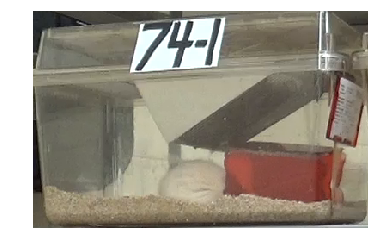

In [125]:
plt.figure()
plt.imshow(np_feed[299].astype(np.uint8))
plt.axis('off')
plt.show()

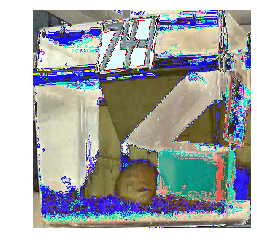

In [126]:
plt.figure()
plt.imshow(((tf_images[299]/2 + 0.5) * 255).astype(np.uint8))
plt.axis('off')
plt.show()